In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "Programming/cs231n/assignment1"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Programming/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/Programming/cs231n/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.320856
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ $ loss \approx 1/{number of classes}$



In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.220477 analytic: -0.220477, relative error: 1.864485e-07
numerical: -1.016692 analytic: -1.016692, relative error: 3.727308e-09
numerical: -1.739858 analytic: -1.739858, relative error: 3.292834e-09
numerical: 0.192879 analytic: 0.192879, relative error: 1.938061e-07
numerical: 0.397703 analytic: 0.397702, relative error: 1.432631e-07
numerical: 2.066248 analytic: 2.066248, relative error: 2.740190e-08
numerical: -0.668667 analytic: -0.668667, relative error: 6.655587e-08
numerical: -1.822385 analytic: -1.822385, relative error: 1.087691e-08
numerical: -1.124609 analytic: -1.124609, relative error: 3.708115e-08
numerical: -0.681343 analytic: -0.681343, relative error: 6.369259e-08
numerical: -1.178575 analytic: -1.178575, relative error: 6.616570e-09
numerical: 1.134135 analytic: 1.134135, relative error: 1.023290e-08
numerical: 0.215217 analytic: 0.215217, relative error: 1.679242e-07
numerical: -1.666911 analytic: -1.666911, relative error: 1.682771e-08
numerical: 0.366

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.320856e+00 computed in 0.174546s
vectorized loss: 2.320856e+00 computed in 0.018533s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [1e3, 2.5e4, 3e4, 3.5e4, 4e4, 5e4, 6e4, 3e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regularization_strengths:
    svm = Softmax()
    svm.train(X_train,y_train,lr,reg,600)
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train==y_train_pred)
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val_pred == y_val)
    results[(lr,reg)] = (train_accuracy,val_accuracy)
    if val_accuracy>best_val:
      best_val = val_accuracy
      best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/drive/My Drive/Programming/cs231n/assignment1/cs231n/classifiers/softmax.py:86: RuntimeWarning: overflow encountered in exp
  sigma = np.sum(np.exp(h), axis = 1 , keepdims=True)
/content/drive/My Drive/Programming/cs231n/assignment1/cs231n/classifiers/softmax.py:89: RuntimeWarning: overflow encountered in exp
  softmax_matrix = np.exp(h) / sigma
/content/drive/My Drive/Programming/cs231n/assignment1/cs231n/classifiers/softmax.py:89: RuntimeWarning: invalid value encountered in true_divide
  softmax_matrix = np.exp(h) / sigma


lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.211102 val accuracy: 0.224000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.322388 val accuracy: 0.344000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.324612 val accuracy: 0.332000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.320469 val accuracy: 0.332000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.312429 val accuracy: 0.325000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.305510 val accuracy: 0.331000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.310714 val accuracy: 0.317000
lr 1.000000e-07 reg 3.000000e+05 train accuracy: 0.260959 val accuracy: 0.281000
lr 5.000000e-05 reg 1.000000e+03 train accuracy: 0.188061 val accuracy: 0.191000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 3.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 3.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 4.000000

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.322000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



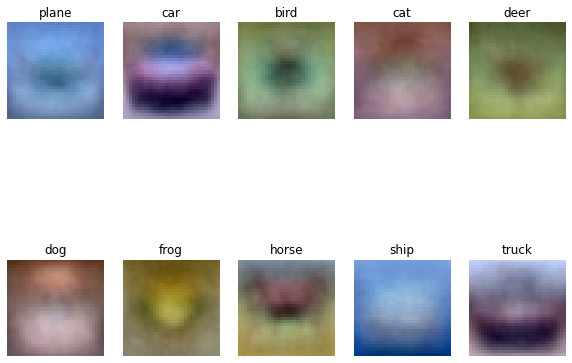

In [ ]:
# Visualize the learned weights for each class
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [ ]:
SM = Softmax()
SM.train(X_train,y_train,1e-7,5e4,1500,verbose = 1)

iteration 0 / 1500: loss 1546.773696
iteration 100 / 1500: loss 208.249014
iteration 200 / 1500: loss 29.690919
iteration 300 / 1500: loss 5.788001
iteration 400 / 1500: loss 2.633522
iteration 500 / 1500: loss 2.205371
iteration 600 / 1500: loss 2.175757
iteration 700 / 1500: loss 2.126796
iteration 800 / 1500: loss 2.131734
iteration 900 / 1500: loss 2.172336
iteration 1000 / 1500: loss 2.153129
iteration 1100 / 1500: loss 2.184405
iteration 1200 / 1500: loss 2.121041
iteration 1300 / 1500: loss 2.158393
iteration 1400 / 1500: loss 2.150442


[1546.7736955440093,
 1516.1930839196295,
 1485.4746142741992,
 1455.9522776325562,
 1426.6191452997755,
 1398.3634033810154,
 1371.1492958195074,
 1343.5166901472094,
 1316.6232735729084,
 1290.2342879726436,
 1264.9758129624568,
 1239.9118356816152,
 1214.9790163465666,
 1190.7273764276463,
 1166.9369434245598,
 1144.0428810770918,
 1120.9869797831964,
 1098.8534480209673,
 1077.0291277268989,
 1055.3842986450177,
 1034.3755565380425,
 1014.0210883714011,
 993.6534787495933,
 974.0391148346685,
 954.342028698756,
 935.5757750221265,
 917.0335468190149,
 898.8311085297522,
 880.7106551159297,
 863.3158195894298,
 846.0594528708497,
 829.1752340866531,
 812.6213155621783,
 796.7830386521762,
 780.7164071604196,
 765.2563904108742,
 750.0229767113373,
 734.9272380325334,
 720.4214430695592,
 705.8781524376476,
 692.1822640514392,
 678.6143511326067,
 664.9033065840366,
 651.7204639225359,
 638.7142996858722,
 625.9992268589916,
 613.5533670227867,
 601.2804466185636,
 589.2681827689956,

In [ ]:
best_svm = SM